<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Structure-cheat-sheet" data-toc-modified-id="Structure-cheat-sheet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Structure cheat sheet</a></span></li><li><span><a href="#Data-structure" data-toc-modified-id="Data-structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data structure</a></span></li><li><span><a href="#get-features" data-toc-modified-id="get-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>get features</a></span></li><li><span><a href="#Pump,-min6dB,-PSD_raw,-all-channels" data-toc-modified-id="Pump,-min6dB,-PSD_raw,-all-channels-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pump, min6dB, PSD_raw, all channels</a></span></li><li><span><a href="#Pump,-min6dB,-PSD_den,-all-channels" data-toc-modified-id="Pump,-min6dB,-PSD_den,-all-channels-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Pump, min6dB, PSD_den, all channels</a></span></li><li><span><a href="#Slider,-min6dB,-PSD_den,-all-channels" data-toc-modified-id="Slider,-min6dB,-PSD_den,-all-channels-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Slider, min6dB, PSD_den, all channels</a></span></li><li><span><a href="#Conclusion-for-PSDs" data-toc-modified-id="Conclusion-for-PSDs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusion for PSDs</a></span></li><li><span><a href="#Pump,-min6dB,-5-framed-MEL_raw" data-toc-modified-id="Pump,-min6dB,-5-framed-MEL_raw-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Pump, min6dB, 5-framed MEL_raw</a></span></li><li><span><a href="#Pump,-min6dB,-5-framed-MEL_den" data-toc-modified-id="Pump,-min6dB,-5-framed-MEL_den-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Pump, min6dB, 5-framed MEL_den</a></span></li><li><span><a href="#Slider,-min6dB,-5-framed-MEL_den" data-toc-modified-id="Slider,-min6dB,-5-framed-MEL_den-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Slider, min6dB, 5-framed MEL_den</a></span></li></ul></div>

# Basics

## Structure cheat sheet

1. func: train data lead (following order)
    1. read the descriptive dataframe from the feature-pipeline
    2. extract feature from the feature-objects which are labeled train-dataset from dataframe
    3. create numpy feature array for the processing pipeline
2. preprocessing
    1. Transformation (any combination of the following)
        + log-transform
        + PCA
        + others
    2. Scaling (one of the following)
        + StandardScaler
        + MinMaxScaler
3. Unsupervised Clustering
    1. Estimate initial hyperparameter
    2. Create grid over various hyperparameters
    3. Train all and choose the best according to metric
    
    
in all steps the cluster-recorder object (possibly dataframe-row) will record all the meta-information like hyper-parameters

## Data structure

There are multiple degrees of freedom in the data:

1. Signal to noise ratio (SNR)
2. Machine type
    1. pump
    2. fan
    3. valve (solenoid)
    4. slider
3. Machine ID
    1. four different machine IDs
    
The pipeline will be applied to fixed SNR, fixed machine type and fixed ID

## get features

Get the descriptive dataframe for the features.

The descriptive dataframe contains all IDs of the pump. We will focus on ID '00' for now since the modeling phase is seperated per SNR, per machine, per ID anyway.

class: 
+ uni\_\<model\>
attributes:
+ default threshold
+ roc_auc
methods:
+ fit
+ predict
+ predict_score
+ eval_roc_auc

In [1]:
#===============================================
# Basic Imports


BASE_FOLDER = '../../'
%run -i ..\..\utility\feature_extractor\JupyterLoad_feature_extractor.py
%run -i ..\..\utility\modeling\JupyterLoad_modeling.py

load feature_extractor_mother
load feature_extractor_mel_spectra
load feature_extractor_psd
load feature_extractor_ICA2
load feature_extractore_pre_nnFilterDenoise
load extractor_diagram_mother
load Simple_FIR_HP
load TimeSliceAppendActivation
load load_data
Load split_data
Load anomaly_detection_models
Load pseudo_supervised_models
Load tensorflow models
Load detection_pipe


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from tqdm import tqdm
from sklearn.metrics import roc_auc_score


In [3]:
def analyze_ica(SNR, ID, machine, feature, func={'function':'frame', 'frames':3}, ica=True):
    diagram = 'extdia_v1'

    tasks = [{
            'path_descr':BASE_FOLDER + 'dataset/{}/{}{}{}_EDiaV1HP_pandaDisc.pkl'.format(diagram, machine, SNR, ID), 
            'feat':func, 
            'feat_col':feature, 
            'SNR':SNR, 
            'machine':machine, 
            'ID':ID,
            'BASE_FOLDER':BASE_FOLDER}]


    tt_split(tasks[0]['path_descr'])

    df_train, data_train = load_data(**tasks[0], train_set=1)
    df_test, data_test = load_data(**tasks[0], train_set=0)

    mse_train = []
    mse_test = []
    mape_train = []
    mape_test = []
    error_train = []
    error_test = []
    xcas = []

    xcs = [2, 4, 8, 16, 32, 64, 128]

    for i in tqdm(xcs):
        if ica:
            xcas.append(FastICA(n_components=i, algorithm='parallel'))
        else:
            xcas.append(PCA(n_components=i))
        data_trans_train = xcas[-1].fit_transform(data_train)
        data_trans_test = xcas[-1].transform(data_test)

        error_train.append(data_train - xcas[-1].inverse_transform(data_trans_train))
        mape_train.append(np.mean(np.mean(np.abs(error_train[-1]/data_train))))
        mse_train.append(np.mean(np.mean(np.square(error_train[-1]))))
        
        error_test.append(data_test - xcas[-1].inverse_transform(data_trans_test))
        mape_test.append(np.mean(np.mean(np.abs(error_test[-1]/data_test))))
        mse_test.append(np.mean(np.mean(np.square(error_test[-1]))))

    error_test_per_instance = []
    roc_auc = []
    y_true = df_test.abnormal
    for i in range(len(error_test)):
        error_test_per_instance.append(np.mean(np.abs(error_test[i]), axis=1))
        roc_auc.append(roc_auc_score(y_true, error_test_per_instance[i]))

    plt.plot(xcs, mape_train, marker='o', label='rel. error train')
    plt.plot(xcs, mape_test, marker='x', label='rel. error test')
    
    if ica: 
        title = 'ica'
    else:
        title = 'pca'
    
    plt.title(title + ' reproduction error [\%] of MEL_denbssm of pump 02');
    plt.legend()
    plt.grid()
    
    return mse_train, mse_test, mape_train, mape_test, error_train, error_test, xcas

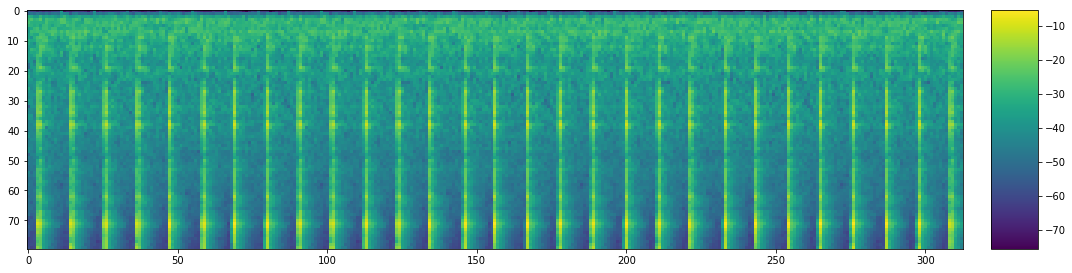

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(15,15))
im = plt.imshow(data[40].reshape(80, 313))
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.tight_layout()

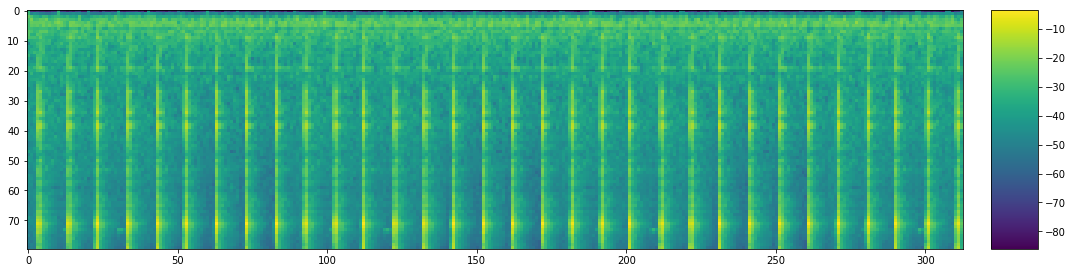

In [75]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(15,15))
im = plt.imshow(data[4].reshape(80, 313))
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.tight_layout()

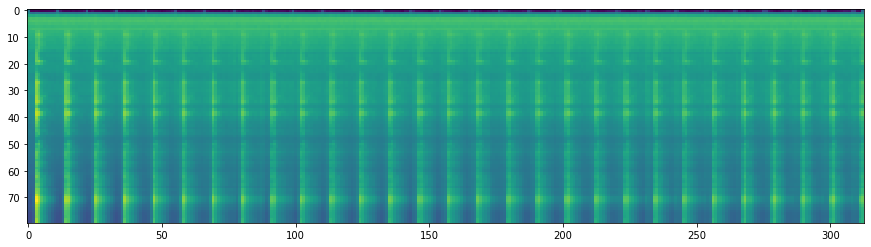

In [60]:
data_trans = icas[0].transform(data)
data_invtrans = icas[0].inverse_transform(data_trans)

plt.figure(figsize=(15,15))
plt.imshow(data_invtrans[40].reshape(80, 313))

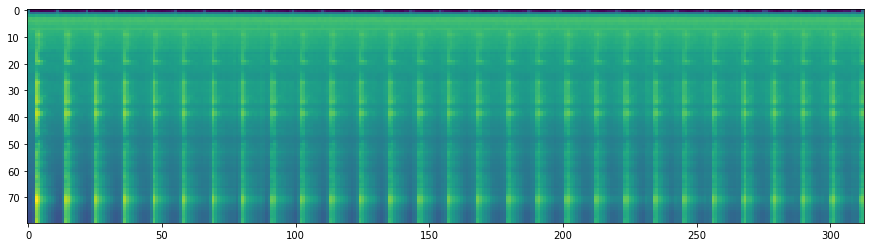

In [61]:
data_trans = icas[1].transform(data)
data_invtrans = icas[1].inverse_transform(data_trans)

plt.figure(figsize=(15,15))
plt.imshow(data_invtrans[40].reshape(80, 313))

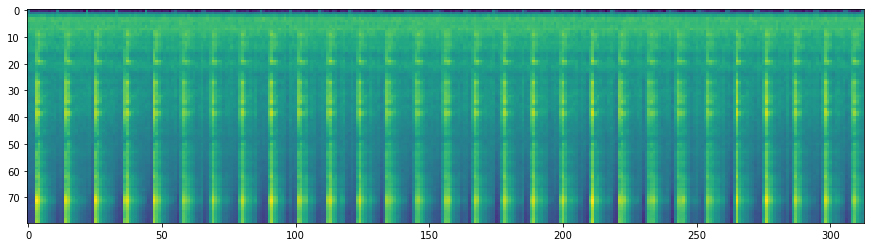

In [62]:
data_trans = icas[-1].transform(data)
data_invtrans = icas[-1].inverse_transform(data_trans)

plt.figure(figsize=(15,15))
plt.imshow(data_invtrans[40].reshape(80, 313))

## Pump, min6dB, PSD_raw, all channels

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


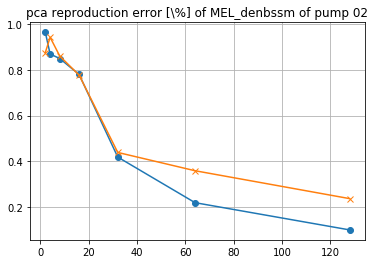

In [15]:
mse_train, mse_test, mape_train, mape_test, error_train, error_test = analyze_ica('min6dB', '02', 'pump', 'PSD_raw', func={'function':'channel'})

## Pump, min6dB, PSD_den, all channels

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.18it/s]


ValueError: too many values to unpack (expected 6)

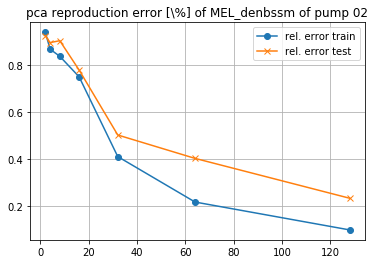

In [25]:
mse_train, mse_test, mape_train, mape_test, error_train, error_test = analyze_ica('min6dB', '02', 'pump', 'PSD_raw', func={'function':'channel'})

## Slider, min6dB, PSD_den, all channels

../../dataset/extdia_v1/slidermin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.71it/s]


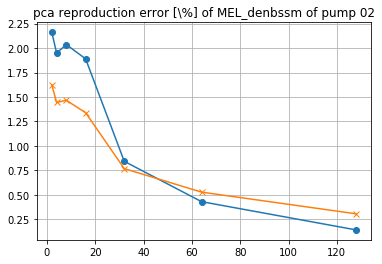

In [17]:
mse_train, mse_test, mape_train, mape_test, error_train, error_test = analyze_ica('min6dB', '02', 'slider', 'PSD_raw', func={'function':'channel'})

## Conclusion for PSDs

PSDs seem to be not profiting from being reduced in dimensionality.

## Pump, min6dB, 5-framed MEL_raw

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [08:40<00:00, 74.32s/it]


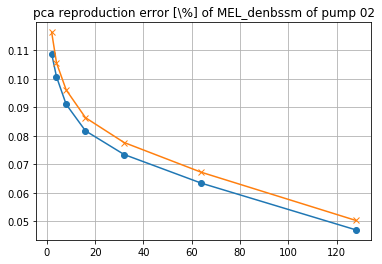

In [18]:
_ = analyze_ica('min6dB', '02', 'pump', 'MEL_raw', func={'function':'frame', 'frames':5})

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 21.45s/it]


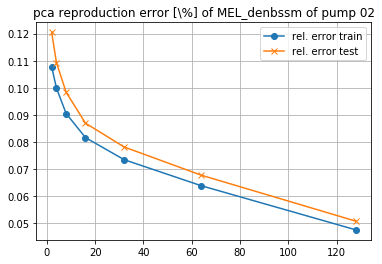

In [26]:
_ = analyze_ica('min6dB', '02', 'pump', 'MEL_raw', func={'function':'frame', 'frames':5}, ica=False)

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.89s/it]


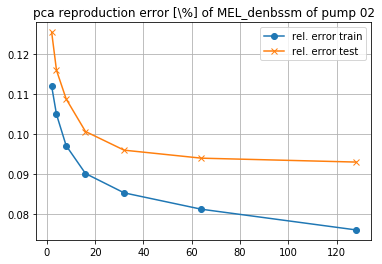

In [4]:
_ = analyze_ica('min6dB', '02', 'pump', 'MEL_raw', func={'function':'flat'}, ica=False)

## Pump, min6dB, 5-framed MEL_den

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:07<00:00, 78.22s/it]


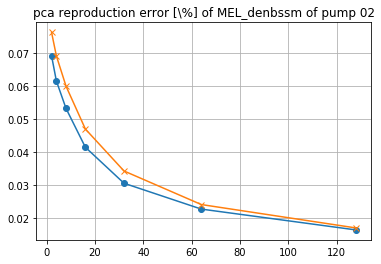

In [19]:
_ = analyze_ica('min6dB', '02', 'pump', 'MEL_den', func={'function':'frame', 'frames':5})

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 21.74s/it]


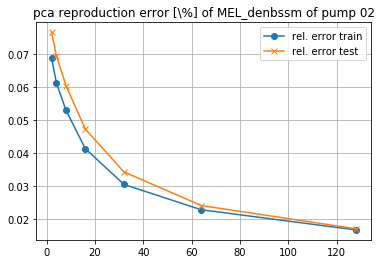

In [27]:
_ = analyze_ica('min6dB', '02', 'pump', 'MEL_den', func={'function':'frame', 'frames':5}, ica=False)

../../dataset/extdia_v1/pumpmin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:26<00:00,  3.85s/it]


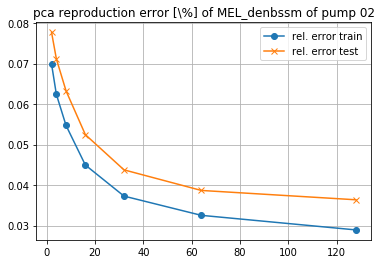

In [5]:
_ = analyze_ica('min6dB', '02', 'pump', 'MEL_den', func={'function':'flat'}, ica=False)

## Slider, min6dB, 5-framed MEL_den

../../dataset/extdia_v1/slidermin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:40<00:00, 57.28s/it]


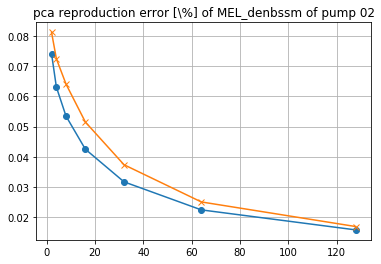

In [20]:
_ = analyze_ica('min6dB', '02', 'slider', 'MEL_den', func={'function':'frame', 'frames':5})

../../dataset/extdia_v1/slidermin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:37<00:00, 13.89s/it]


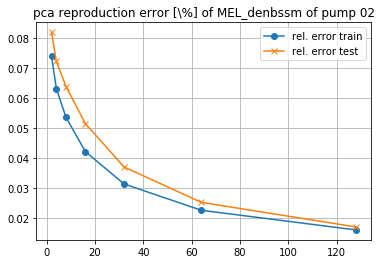

In [28]:
_ = analyze_ica('min6dB', '02', 'slider', 'MEL_den', func={'function':'frame', 'frames':5}, ica=False)

../../dataset/extdia_v1/slidermin6dB02_EDiaV1HP_pandaDisc.pkl --> Done


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.61s/it]


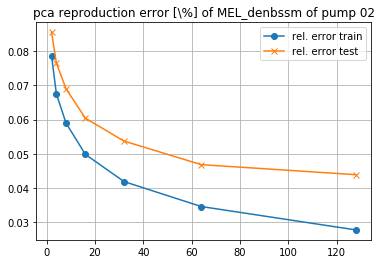

In [6]:
_ = analyze_ica('min6dB', '02', 'slider', 'MEL_den', func={'function':'flat'}, ica=False)

From the exploration of the Dimensionality Reduction we can derive the following rules of thumb:

1. PCA and ICA deliver almost the same results looking at the relative absolute error
2. PCA is usually much faster
3. on PSD and the ICA demix matrix, no dimensionality reduction is needed
4. for a 5-framed Mel-spectrum a number of components between 32 and 64 is a good measure. The resulting error is about 2-4%
5. for a whole Mel-spectrum a number of components between 64 and 128 is advised